In [1]:
import glob
import numpy as np
import pandas as pd
from scipy import stats

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

from scipy.optimize import curve_fit


from astropy.time import Time
import requests
import io

import astropy.units as u
# from astropy.coordinates import SkyCoord
# from astropy.coordinates import angular_separation

from astropy.modeling import models, fitting
from scipy import special

from fink_utils.sso import spins as finkus
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [4]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']


In [5]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [6]:
data

,ssnamenr,HG_dG_g,HG_fit,HG_rms,HG_chi2red,HG_dH_g,HG_dG_r,HG_dH_r,HG_rms_r,HG_rms_g,...,SHG1G2_H_g,SHG1G2_dR,SHG1G2_mean_cos_lambda,SHG1G2_alpha0,SHG1G2_status,name,number,SHG1G2_obliquity,version,SHG1G2_flag
0,21300,0.025703,0.0,0.086984,2.229792,0.026820,0.029495,0.031345,0.090271,0.083610,...,15.000101,0.055727,0.300001,169.293137,2.0,1996 WA1,21300,95.722128,2023.08,0
1,69159,0.071497,0.0,0.088811,0.756170,0.087157,0.066691,0.085704,0.100006,0.077046,...,15.381413,0.389061,0.062653,258.326508,3.0,Ivanking,69159,127.291547,2023.08,0
2,156570,0.108358,0.0,0.078103,0.355749,0.072178,0.055870,0.047413,0.080191,0.072460,...,15.905060,0.187448,0.208441,168.216888,2.0,2002 EF102,156570,155.601702,2023.08,0
3,26802,0.058523,0.0,0.090832,0.849256,0.048446,0.047541,0.041295,0.096186,0.079989,...,15.937100,0.838627,0.310432,257.191772,3.0,1981 EJ24,26802,26.396108,2023.08,0
4,57076,0.064012,0.0,0.134873,2.791821,0.062520,0.071418,0.071429,0.135482,0.134172,...,15.920240,0.148588,0.163675,189.528946,2.0,2001 OY16,57076,69.969325,2023.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112399,4078,0.059994,0.0,0.152370,17.600145,0.066864,0.062534,0.070002,0.163346,0.141849,...,11.218876,0.351671,0.366967,240.681610,2.0,Polakis,4078,23.972038,2023.08,0
112400,9248,0.027454,0.0,0.084954,1.489366,0.025768,0.026321,0.026031,0.096568,0.068743,...,14.348174,0.540346,0.292096,230.158936,2.0,Sauer,9248,23.624176,2023.08,0
112401,240222,0.306755,0.0,0.172862,1.538694,0.142191,0.186895,0.091009,0.174961,0.167894,...,15.392922,0.201070,0.455892,147.674118,2.0,2002 TY3,240222,126.019176,2023.08,0
112402,88765,0.215753,0.0,0.277356,8.366850,0.163016,0.125002,0.112766,0.283138,0.267441,...,16.654705,0.762177,0.171686,104.755066,0.0,2001 SY67,88765,143.343386,2023.08,0


In [7]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1._alpha0.value', 'spins.1._delta0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2._alpha0.value', 'spins.2._delta0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3._alpha0.value', 'spins.3._delta0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4._alpha0.value', 'spins.4._delta0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

bft = pd.read_parquet(bft_file, columns=cols)
data = data.merge( bft, left_on='name', right_on='sso_name', how='left' )


In [8]:
len(data)

112404

# Compare results

In [9]:
data.HG1G2_status.value_counts()

 2.0    103895
 4.0      6482
 1.0      1226
 3.0       516
-2.0       280
 0.0         5
Name: HG1G2_status, dtype: int64

In [10]:
list(data.columns)

['ssnamenr',
 'HG_dG_g',
 'HG_fit',
 'HG_rms',
 'HG_chi2red',
 'HG_dH_g',
 'HG_dG_r',
 'HG_dH_r',
 'HG_rms_r',
 'HG_rms_g',
 'HG_G_g',
 'HG_H_r',
 'HG_H_g',
 'HG_G_r',
 'HG_status',
 'HG_flag',
 'HG1G2_fit',
 'HG1G2_dG2_g',
 'HG1G2_dG1_r',
 'HG1G2_dG1_g',
 'HG1G2_rms',
 'HG1G2_dG2_r',
 'HG1G2_G2_g',
 'HG1G2_G1_r',
 'HG1G2_G1_g',
 'HG1G2_G2_r',
 'HG1G2_chi2red',
 'HG1G2_dH_g',
 'HG1G2_dH_r',
 'HG1G2_rms_r',
 'HG1G2_rms_g',
 'HG1G2_H_r',
 'HG1G2_H_g',
 'HG1G2_status',
 'HG1G2_flag',
 'mean_astrometry',
 'max_phase_g',
 'max_phase_r',
 'SHG1G2_max_cos_lambda',
 'SHG1G2_fit',
 'SHG1G2_R',
 'SHG1G2_min_cos_lambda',
 'n_obs',
 'SHG1G2_dG2_g',
 'SHG1G2_dG1_r',
 'n_days',
 'SHG1G2_dG1_g',
 'SHG1G2_rms',
 'SHG1G2_dG2_r',
 'SHG1G2_G2_g',
 'SHG1G2_G1_r',
 'SHG1G2_ddelta0',
 'SHG1G2_G1_g',
 'std_astrometry',
 'SHG1G2_delta0',
 'n_days_r',
 'SHG1G2_G2_r',
 'n_days_g',
 'SHG1G2_chi2red',
 'min_phase',
 'SHG1G2_dH_g',
 'SHG1G2_dH_r',
 'SHG1G2_rms_r',
 'last_jd',
 'SHG1G2_rms_g',
 'min_phase_r',
 'n_o

In [14]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_SHG1G2_g = (data.SHG1G2_G1_g>thres)  & (data.SHG1G2_G2_g>thres) & ((1-data.SHG1G2_G1_g-data.SHG1G2_G2_g)>thres)
mask_SHG1G2_r = (data.SHG1G2_G1_r>thres)  & (data.SHG1G2_G2_r>thres) & ((1-data.SHG1G2_G1_r-data.SHG1G2_G2_r)>thres)
mask_SHG1G2_ZTF = mask_SHG1G2_g & mask_SHG1G2_r
mask_SHG1G2_fit = (data.SHG1G2_fit==0)  & (data.SHG1G2_status>=2)
mask_SHG1G2 = mask_SHG1G2_fit & mask_SHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.SHG1G2_alpha0>thres) & ( np.abs(360-data.SHG1G2_alpha0)>thres )  & \
           ( np.abs(data.SHG1G2_alpha0-180)>thres) & ( np.abs(data.SHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.min_phase<2.5

# Global mask
mask = mask_HG1G2 & mask_SHG1G2


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_SHG1G2_g]):6d}  ({100.*len(data[mask_SHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_SHG1G2_r]):6d}  ({100.*len(data[mask_SHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_SHG1G2]):6d}  ({100.*len(data[mask_SHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for min_phase in [2,3,4,5]:
    maskPhase = data.min_phase<min_phase
    print(f'  Mask phase {min_phase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_SHG1G2_g]), len(data[mask_SHG1G2_r]), len(data[mask_SHG1G2])

 All data       : 112404  (100.00%)

  Mask HG g      : 112120  ( 99.75%)
  Mask HG r      : 112121  ( 99.75%)
  Mask HG g+r    : 109955  ( 97.82%)

  Mask HG1G2 g   :  57323  ( 51.00%)
  Mask HG1G2 r   :  62116  ( 55.26%)
  Mask HG1G2 g+r :  42027  ( 37.39%)

  Mask SHG1G2 g  :  71733  ( 63.82%)
  Mask SHG1G2 r  :  76365  ( 67.94%)
  Mask SHG1G2 g+r:  57511  ( 51.16%)

  Mask Spin      : 108758  ( 96.76%)

  Mask (both)    :  36180  ( 32.19%)
  Mask phase 2  :  55190  ( 49.10%)
  Mask phase 3  :  76507  ( 68.06%)
  Mask phase 4  :  90348  ( 80.38%)
  Mask phase 5  :  98575  ( 87.70%)


## Difference in absolute magnitude

In [15]:
data.columns[:40]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit'],
      dtype='object')

In [18]:
data[~mask_HG_r]

,ssnamenr,HG_dG_g,HG_fit,HG_rms,HG_chi2red,HG_dH_g,HG_dG_r,HG_dH_r,HG_rms_r,HG_rms_g,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
159,2004RP215,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
600,2016TN84,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1863,2003SE44,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1898,2016ED85,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2139,2016NM20,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111056,2004VT11,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
111655,2007OR01,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
111747,2006BE42,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
111944,2006DE149,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [19]:
data.columns[:80]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit', 'SHG1G2_R',
       'SHG1G2_min_cos_lambda', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_G2_g',
       'SHG1G2_G1_r', 'SHG1G2_ddelta0', 'SHG1G2_G1_g', 'std_astrometry',
       'SHG1G2_delta0', 'n_days_r', 'SHG1G2_G2_r', 'n_days_g',
       'SHG1G2_chi2red', 'min_phase', 'SHG1G2_dH_g', 'SHG1G2_dH_r',
       'SHG1G2_rms_r', 'last_jd', 'SHG

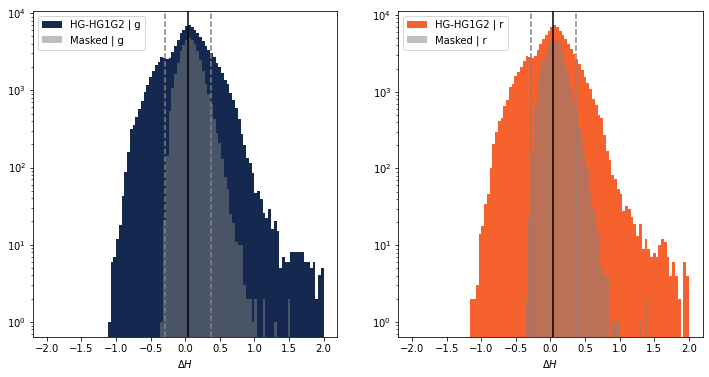

In [26]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_HG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'eltaH_HG_HG1G2.png'), facecolor='white')

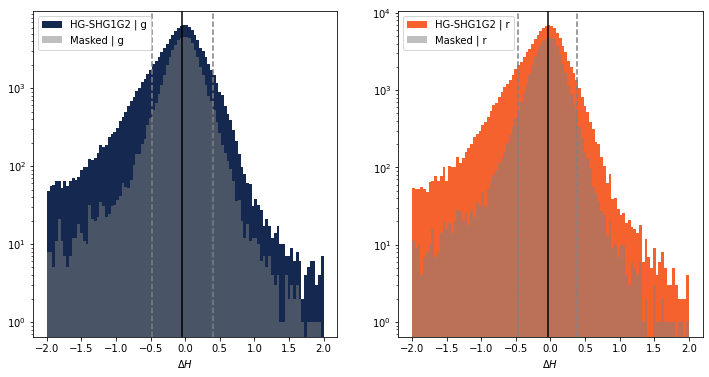

In [24]:
# HG vs SHG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'SHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-SHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_SHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )
    
    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG_SHG1G2.png'), facecolor='white')

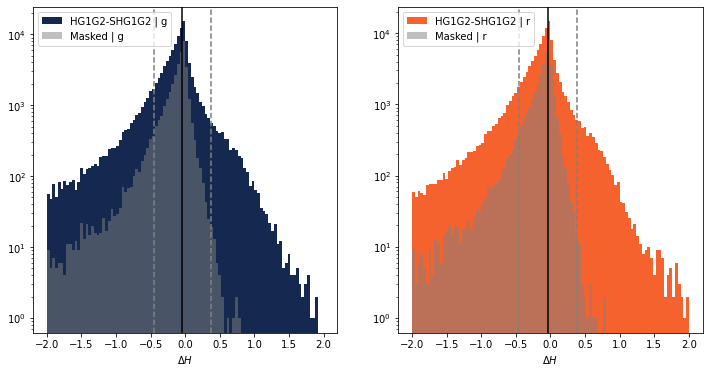

In [25]:
# HG vs SHG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG1G2_H_{f}'] - data[f'SHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG1G2-SHG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_HG1G2&mask_SHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG1G2_SHG1G2.png'), facecolor='white')

- HG seems to fail as expected
- HG1G2 vs spin non symmetric: effect of oppositions
- Hspin often smaller

Apparently a systematic larger value of H (HG) wrt H (hybrid)

H_s = m - f - g - s
    = H - s

so
H_S - H = - s
 s s always negative -> H_S - H > 0
  
unless the issues with geometry are modifying g, so everything is messed up in non-hybrid model!
  

1 HG_H_r HG1G2_H_r
2 HG_H_r SHG1G2_H_r
3 HG1G2_H_r SHG1G2_H_r


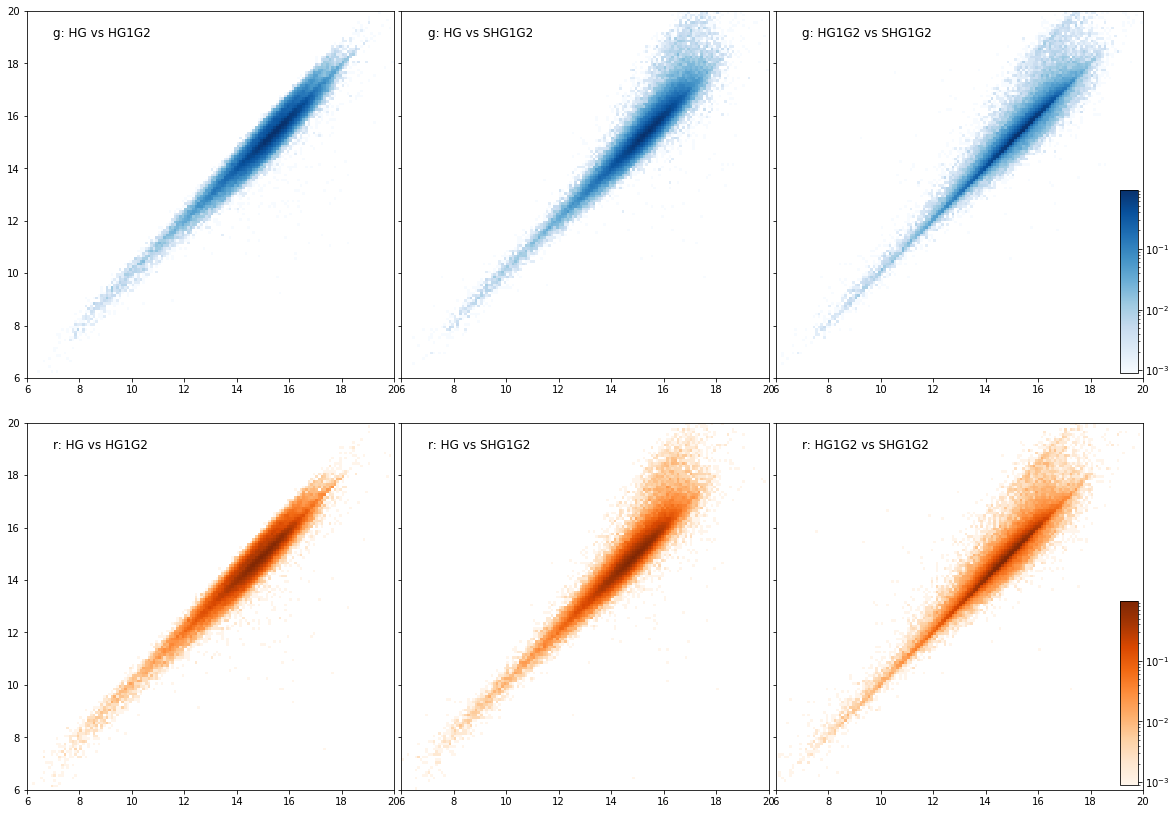

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(20,15), gridspec_kw={'hspace':0.02, 'wspace':0.02})

hh_r = [ [0,22], [0,22] ]
bb_r = np.array([1,1]) * 88
xlab, ylab = 2,20

hh_r = [ [6,20], [6,20] ]
bb_r = np.array([1,1]) * (hh_r[0][1] - hh_r[0][0])*10
xlab, ylab = 7,19

models = ['HG','HG1G2','SHG1G2']
for i in range(3):
    for j in range(i+1,3):

        mx = models[i]
        my = models[j]
        loc_f = 'r'
        print( i+j, f'{mx}_H_{loc_f}', f'{my}_H_{loc_f}' )
        
        # Filter g
        x = data[f'{mx}_H_g']
        y = data[f'{my}_H_g']
        loc_cmap = 'Blues' 
        _ , _, _, img = ax[0,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm=mpl.colors.LogNorm(), density=True )
        ax[0,i+j-1].text( xlab, ylab, f'g: {mx} vs {my}', fontsize='large' )
        
        # Filter r
        x = data[f'{mx}_H_r']
        y = data[f'{my}_H_r']
        loc_cmap = 'Oranges' 
        _ , _, _, imr = ax[1,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm=mpl.colors.LogNorm(), density=True )
        ax[1,i+j-1].text( xlab, ylab, f'r: {mx} vs {my}', fontsize='large' )

        ax[0,i+j-1].set_aspect('equal')
        ax[1,i+j-1].set_aspect('equal')
        
        if (i+j-1)>0:
            ax[0,i+j-1].set_yticklabels('')
            ax[1,i+j-1].set_yticklabels('')
    
axinsg = inset_axes(
    ax[0,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(img, cax=axinsg)


axinsr = inset_axes(
    ax[1,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(imr, cax=axinsr)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'scatterH_HG1G2_SHG1G2.png'), facecolor='white')

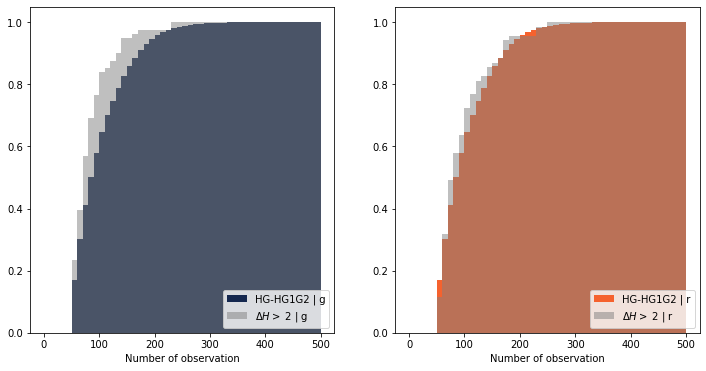

In [44]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,500]
b = 50
lim_delta_H = 2

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > lim_delta_H
    
    ax[i].hist( data['n_obs'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'n_obs'], range=r, bins=b, label=f'$\Delta H >$ {lim_delta_H} | {f}', color='grey', alpha=0.5, density=True, cumulative=True )

    ax[i].set_xlabel('Number of observation')
    ax[i].legend(loc='lower right')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'n_obs.png'), facecolor='white')

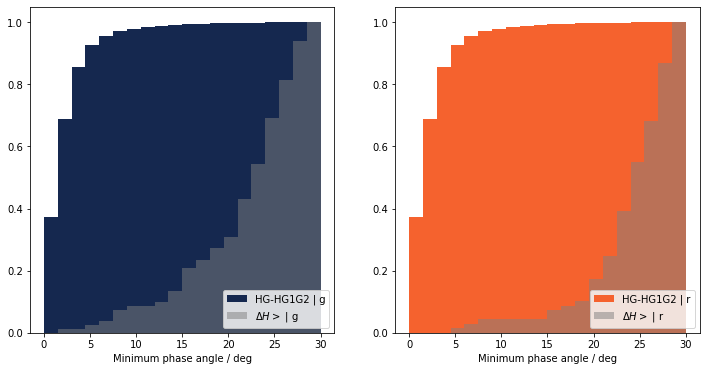

In [43]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [0,30]
b = 20
lim_delta_H = 2

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']
    cond = np.abs(x) > lim_delta_H
    
    ax[i].hist( data['min_phase'], range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i], density=True, cumulative=True )
    ax[i].hist( data.loc[cond, 'min_phase'], range=r, bins=b, label=f'$\Delta H >$ | {f}', color='grey', alpha=0.5, density=True, cumulative=True )
    ax[i].legend(loc='lower right')

    ax[i].set_xlabel('Minimum phase angle / deg')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'min_phase.png'), facecolor='white')

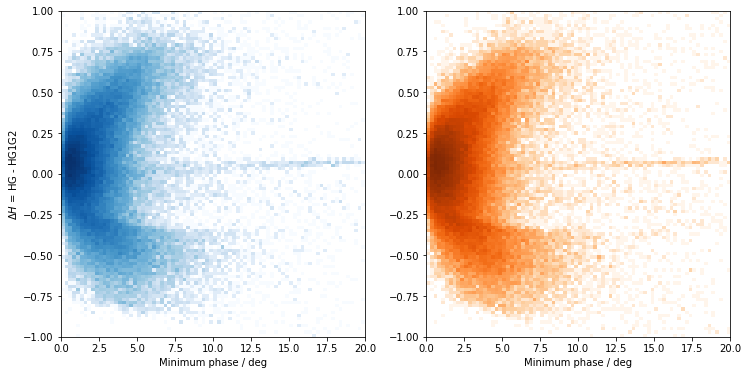

In [42]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'min_phase']
    y = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm=mpl.colors.LogNorm(), density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - HG1G2')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_vs_phase_HG_HG1G2.png'), facecolor='white')

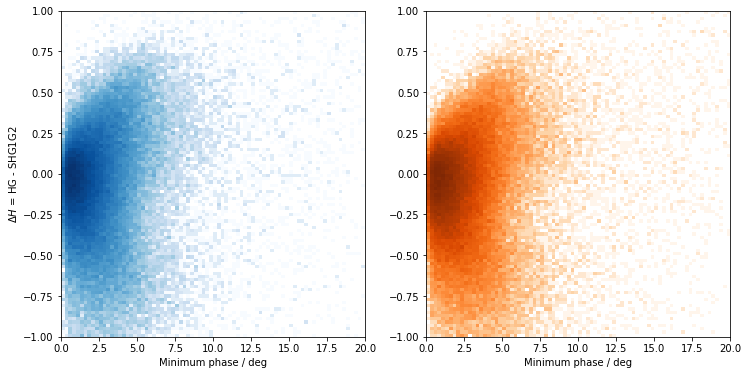

In [41]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'min_phase']
    y = data[f'HG_H_{f}'] - data[f'SHG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm=mpl.colors.LogNorm(), density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG - SHG1G2')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_vs_phase_HG_SHG1G2.png'), facecolor='white')

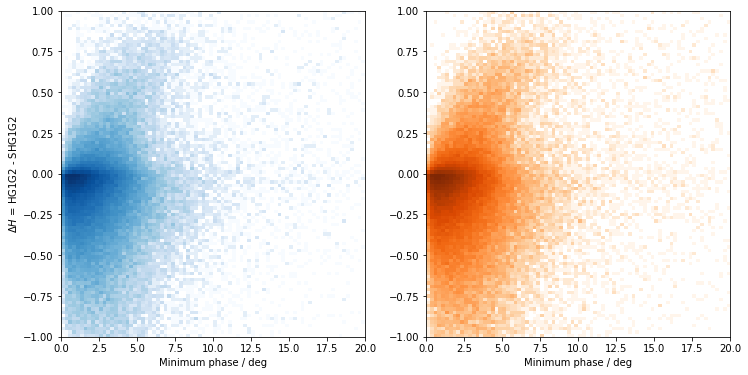

In [33]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

hh_r = [ [0,20], [-1,1] ]
bb_r = [80,100]
xlab, ylab = 2,20


statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'min_phase']
    y = data[f'HG1G2_H_{f}'] - data[f'SHG1G2_H_{f}']

    if f=='g':
        loc_cmap = 'Blues' 
    else:
        loc_cmap = 'Oranges' 
    ax[i].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm=mpl.colors.LogNorm(), density=True )

    ax[i].set_xlabel('Minimum phase / deg')
    
ax[0].set_ylabel('$\Delta H$ = HG1G2 - SHG1G2')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_vs_phase_HG1G2_SHG1G2.png'), facecolor='white')

## Colors

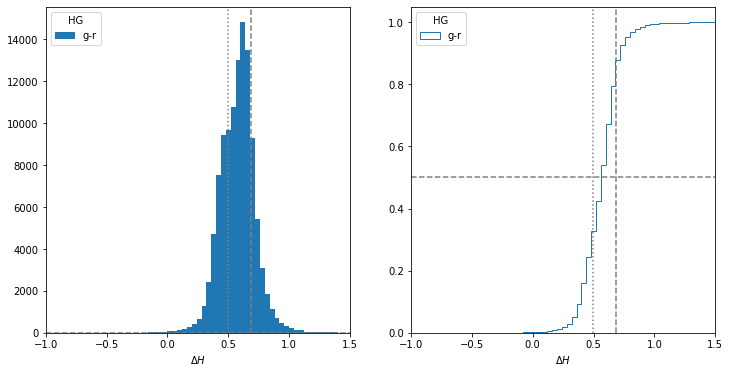

In [34]:
# HG colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG_H_g - data.HG_H_r
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_HG.png'), facecolor='white')

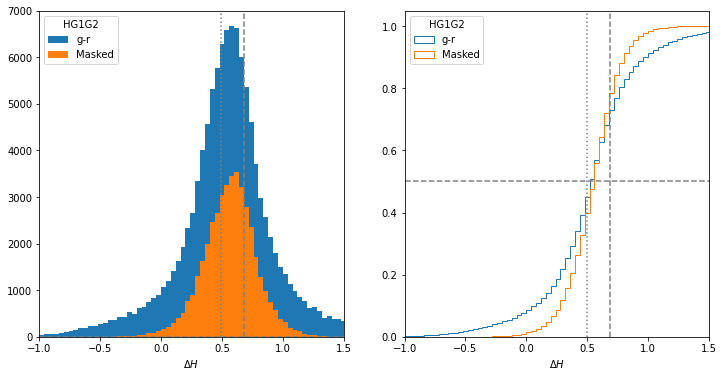

In [35]:
# HG1G2 colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.HG1G2_H_g - data.HG1G2_H_r
loc_mask = mask_HG1G2
ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left', title='HG1G2')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_HG1G2.png'), facecolor='white')

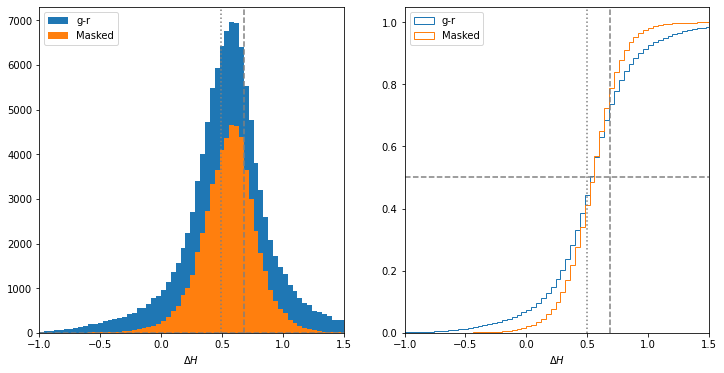

In [37]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

x = data.SHG1G2_H_g - data.SHG1G2_H_r
loc_mask = mask_SHG1G2 & (data.min_phase<2.5) # Test min_phase influence
loc_mask = mask_SHG1G2 

ax[0].hist( x, range=r, bins=b, label='g-r' )
ax[0].hist( x[loc_mask], range=r, bins=b, label='Masked' )

ax[1].hist( x, range=r, bins=b, density=True, cumulative=True, histtype='step', label='g-r' )
ax[1].hist( x[loc_mask], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Masked' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_xlim( -1, 1.5 )
    a.axhline(0.5, color='gray', linestyle='--')
    a.axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')
    a.axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')

# ax[0].set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'color_SHG1G2.png'), facecolor='white')

In [38]:
data.columns[:80]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit', 'SHG1G2_R',
       'SHG1G2_min_cos_lambda', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_G2_g',
       'SHG1G2_G1_r', 'SHG1G2_ddelta0', 'SHG1G2_G1_g', 'std_astrometry',
       'SHG1G2_delta0', 'n_days_r', 'SHG1G2_G2_r', 'n_days_g',
       'SHG1G2_chi2red', 'min_phase', 'SHG1G2_dH_g', 'SHG1G2_dH_r',
       'SHG1G2_rms_r', 'last_jd', 'SHG

N with colors:  20621


U    101451
S      9069
C      1884
Name: ztf_complex, dtype: int64

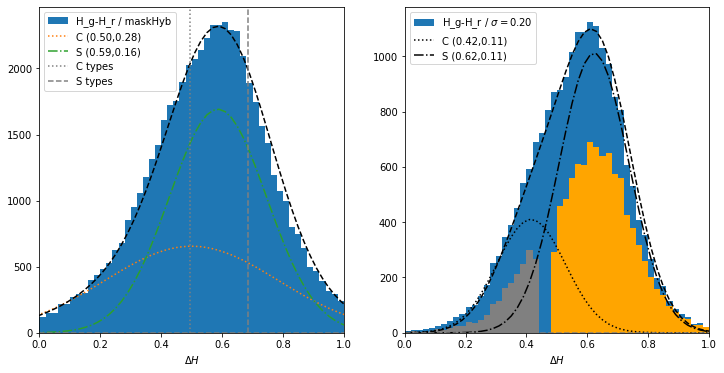

In [39]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-0.5,1.5]
b = 100

cond = mask_SHG1G2
dH = data.loc[cond,'SHG1G2_H_g'] - data.loc[cond,'SHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[0].hist( dH, range=r, bins=b, label='H_g-H_r / maskHyb' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[0].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[0].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[0].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[0].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[0].axvline( color_S, color='gray', linestyle='dashed', label='S types')


unc_H = 0.2
cond = mask_SHG1G2 * \
       (data['SHG1G2_dH_g']<unc_H) * \
       (data['SHG1G2_dH_r']<unc_H)
dH = data.loc[cond,'SHG1G2_H_g'] - data.loc[cond,'SHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'H_g-H_r / $\sigma={unc_H:.2f}$' )
print('N with colors: ', len(data[cond]) )

# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[1].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), color='k', ls='dotted')
ax[1].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), color='k', ls='dashdot')
ax[1].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

# ax[1].axvline( color_C, color='gray', linestyle='dotted', label='C types')
# ax[1].axvline( color_S, color='gray', linestyle='dashed', label='S types')



# ----
sqrt2 = np.sqrt(2.0)
A1 = popt[0]
mu1 = popt[1]
std1 = popt[2]

A2 = popt[3]
mu2 = popt[4]
std2 = popt[5]


x1 = (data['SHG1G2_H_g'] - data['SHG1G2_H_r']) - (data['SHG1G2_dH_g'] - data['SHG1G2_dH_r'])
x2 = (data['SHG1G2_H_g'] - data['SHG1G2_H_r']) + (data['SHG1G2_dH_g'] - data['SHG1G2_dH_r'])

pC = (A1*special.erf((x2 - mu1) / (sqrt2 * std1)) - 
          A1*special.erf((x1 - mu1) / (sqrt2 * std1)))
pS = (A2*special.erf((x2 - mu2) / (sqrt2 * std2)) - 
          A2*special.erf((x1 - mu2) / (sqrt2 * std2)))

# Add Class to DataFrame
data['ztf_pC'] = 0.0
data['ztf_pS'] = 0.0
data['ztf_complex'] = 'U'

cond_z = (pC + pS) > 0
data.loc[cond_z, 'ztf_pC'] = pC[cond_z] / (pC[cond_z] + pS[cond_z])
data.loc[cond_z, 'ztf_pS'] = pS[cond_z] / (pC[cond_z] + pS[cond_z])

rate = 0.2
condS = data['ztf_pS'] - data['ztf_pC'] > rate
data.loc[condS, 'ztf_complex'] = 'S'
data.loc[condS, 'ztf_pcomplex'] = data.loc[cond, 'ztf_pS']
condC = data['ztf_pC'] - data['ztf_pS'] > rate
data.loc[condC, 'ztf_complex'] = 'C'

#cleaning

data.loc[~cond,'ztf_complex'] = 'U'

cond = mask_SHG1G2 * \
       (data['SHG1G2_dH_g']<unc_H) * \
       (data['SHG1G2_dH_r']<unc_H) * \
       (data['ztf_complex']=='C')
dH = data.loc[cond,'SHG1G2_H_g'] - data.loc[cond,'SHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='gray' )

cond = mask_SHG1G2 * \
       (data['SHG1G2_dH_g']<unc_H) * \
       (data['SHG1G2_dH_r']<unc_H) * \
       (data['ztf_complex']=='S')
dH = data.loc[cond,'SHG1G2_H_g'] - data.loc[cond,'SHG1G2_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, color='orange' )


for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.axhline(0.5, color='gray', linestyle='--')
    a.set_xlim(0,1)

# fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r.png', facecolor='white')

data['ztf_complex'].value_counts()


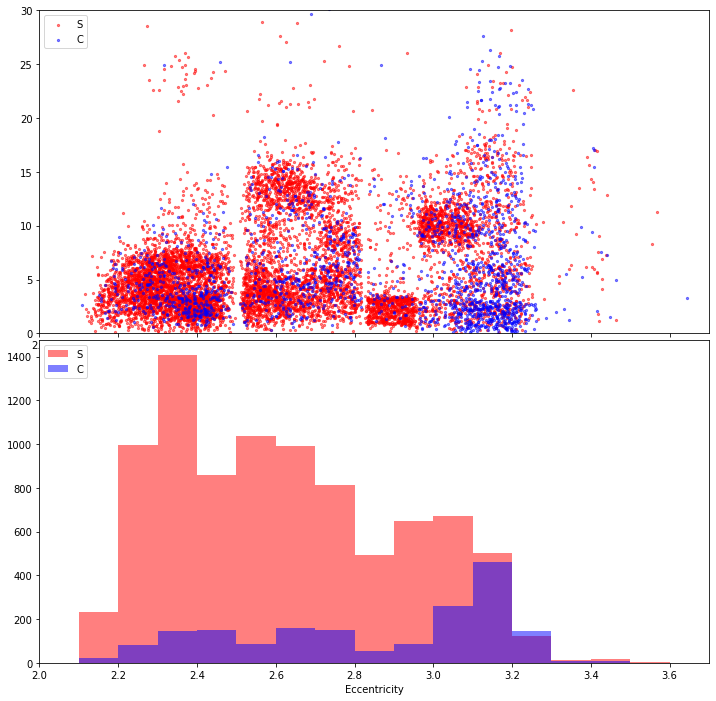

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), gridspec_kw={'hspace':0.02})

s = 20
alpha = 0.5
alp = 0.5
C = (data['ztf_complex'] == 'C')
S = (data['ztf_complex'] == 'S')

# a i
ax[0].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
               data.loc[S,'orbital_elements.inclination.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
ax[0].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
               data.loc[C,'orbital_elements.inclination.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

# hist a
r = [2,3.7]
b = 17
ax[1].hist( data.loc[S,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='red', label='S', alpha=alp )
ax[1].hist( data.loc[C,'orbital_elements.semi_major_axis.value'], range=r, bins=b, color='blue', label='C', alpha=alp )

# a e
# ax[1].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
#                data.loc[S,'orbital_elements.eccentricity.value'], color='red', label='S', marker='.', s=s, alpha=alpha)
# ax[1].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
#                data.loc[C,'orbital_elements.eccentricity.value'], color='blue', label='C', marker='.', s=s, alpha=alpha)

for a in ax:
    a.set_xlim(r)
    a.legend(loc='upper left')

ax[0].set_ylim(0,30)
# ax[1].set_ylim(0,0.6)
ax[0].set_xlabel('Semi-major axis / au')
ax[0].set_xlabel('Inclination / deg')
ax[1].set_xlabel('Eccentricity')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'aei_C_S.png'), facecolor='white')

# G1G2 distribution

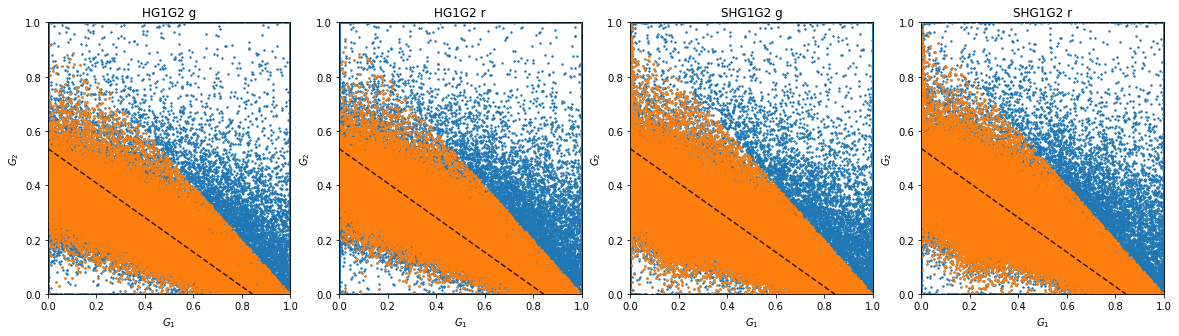

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

r = [-2,2]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0].scatter( x, y, s=2 )
ax[0].scatter( x[mask_HG1G2], y[mask_HG1G2], s=2 )
ax[0].set_title('HG1G2 g', ha='center', fontsize='large') 

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[1].scatter( x, y, s=2 )
ax[1].scatter( x[mask_HG1G2], y[mask_HG1G2], s=2 )
ax[1].set_title('HG1G2 r', ha='center', fontsize='large') 

x = data.SHG1G2_G1_g
y = data.SHG1G2_G2_g
ax[2].scatter( x, y, s=2 )
ax[2].scatter( x[mask_SHG1G2], y[mask_SHG1G2], s=2 )
ax[2].set_title('SHG1G2 g', ha='center', fontsize='large') 

x = data.SHG1G2_G1_r
y = data.SHG1G2_G2_r
ax[3].scatter( x, y, s=2 )
ax[3].scatter( x[mask_SHG1G2], y[mask_SHG1G2], s=2 )
ax[3].set_title('SHG1G2 r', ha='center', fontsize='large') 


for a in ax:
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_scatter.png'), facecolor='white')

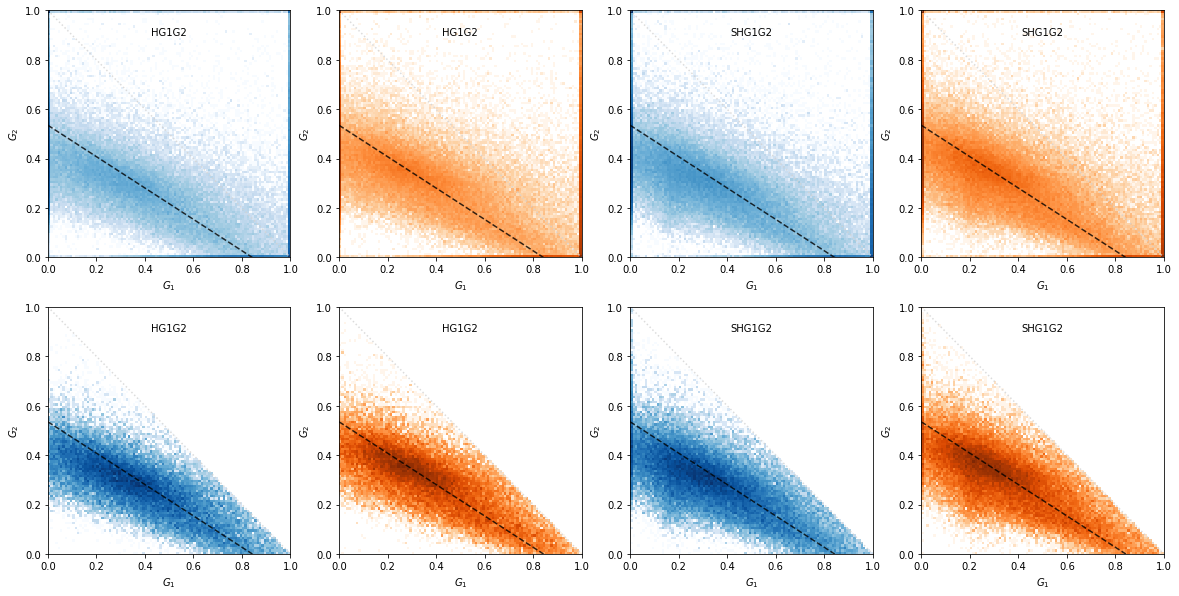

In [47]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

r = [0,1]
b = 100


x = data.HG1G2_G1_g
y = data.HG1G2_G2_g
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues' )
ax[1,0].hist2d( x[mask_HG1G2], y[mask_HG1G2], range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues' )

x = data.HG1G2_G1_r
y = data.HG1G2_G2_r
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges' )
ax[1,1].hist2d( x[mask_HG1G2], y[mask_HG1G2], range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges' )

x = data.SHG1G2_G1_g
y = data.SHG1G2_G2_g
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues' )
ax[1,2].hist2d( x[mask_SHG1G2], y[mask_SHG1G2], range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues' )

x = data.SHG1G2_G1_r
y = data.SHG1G2_G2_r
ax[0,3].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges' )
ax[1,3].hist2d( x[mask_SHG1G2], y[mask_SHG1G2], range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges' )


for a in ax.ravel():
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    
    # G12 line
    xx = np.linspace(0,1,num=5)    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="black", alpha=0.8)
    a.plot(xx, 1-xx, linestyle="dotted", color="lightgrey", alpha=0.8)

for a in ax[:,0:2].ravel():
    a.text(0.5,0.9, 'HG1G2', ha='center' )

for a in ax[:,2:].ravel():
    a.text(0.5,0.9, 'SHG1G2', ha='center' )
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_hist.png'), facecolor='white')

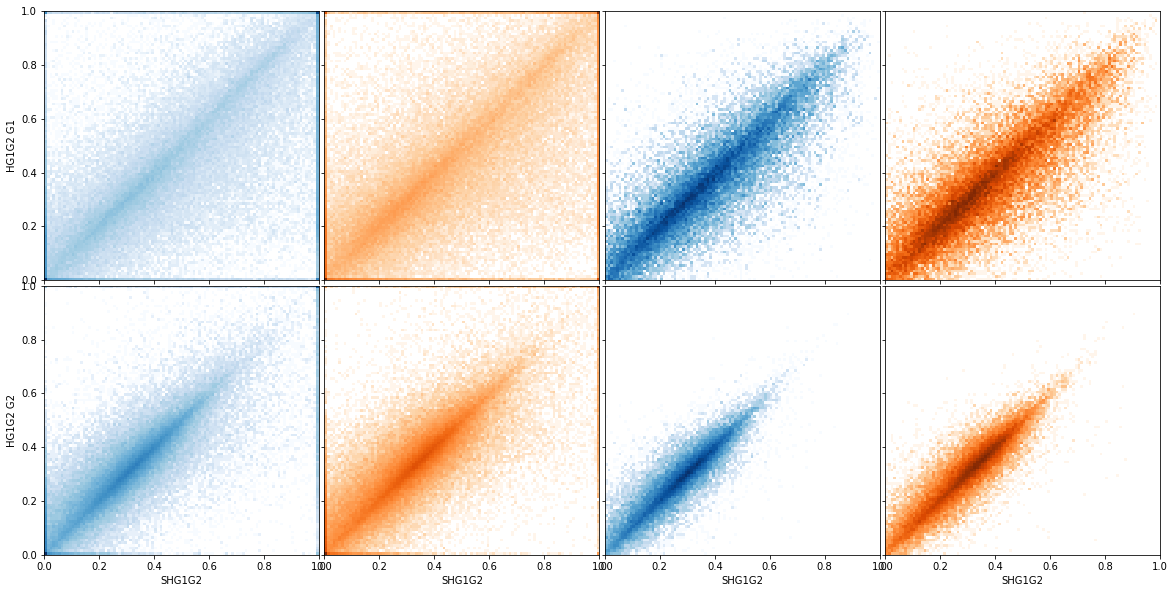

In [48]:
# Overall comparison of G1 G2
fig, ax = plt.subplots(2, 4, figsize=(20,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

# ax = axs.ravel() 
r = [0,1]
b = 100

mm = mask_HG1G2 & mask_SHG1G2


ax[0,0].hist2d( data.HG1G2_G1_g, data.SHG1G2_G1_g, density=True, range=[r,r], bins=b, cmap='Blues', norm=mpl.colors.LogNorm() )
ax[0,1].hist2d( data.HG1G2_G1_r, data.SHG1G2_G1_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm=mpl.colors.LogNorm() )
ax[0,2].hist2d( data.HG1G2_G1_g[mm], data.SHG1G2_G1_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm=mpl.colors.LogNorm() )
ax[0,3].hist2d( data.HG1G2_G1_r[mm], data.SHG1G2_G1_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm=mpl.colors.LogNorm() )

ax[1,0].hist2d( data.HG1G2_G2_g, data.SHG1G2_G2_g, density=True, range=[r,r], bins=b, cmap='Blues', norm=mpl.colors.LogNorm() )
ax[1,1].hist2d( data.HG1G2_G2_r, data.SHG1G2_G2_r, density=True, range=[r,r], bins=b, cmap='Oranges', norm=mpl.colors.LogNorm() )
ax[1,2].hist2d( data.HG1G2_G2_g[mm], data.SHG1G2_G2_g[mm], density=True, range=[r,r], bins=b, cmap='Blues', norm=mpl.colors.LogNorm() )
ax[1,3].hist2d( data.HG1G2_G2_r[mm], data.SHG1G2_G2_r[mm], density=True, range=[r,r], bins=b, cmap='Oranges', norm=mpl.colors.LogNorm() )

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')

ax[0,0].set_ylabel('HG1G2 G1')
ax[1,0].set_ylabel('HG1G2 G2')

for a in ax[1,:]:
    a.set_xlabel('SHG1G2')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'G1G2_comparison.png'), facecolor='white')

## RMS and Chi-square

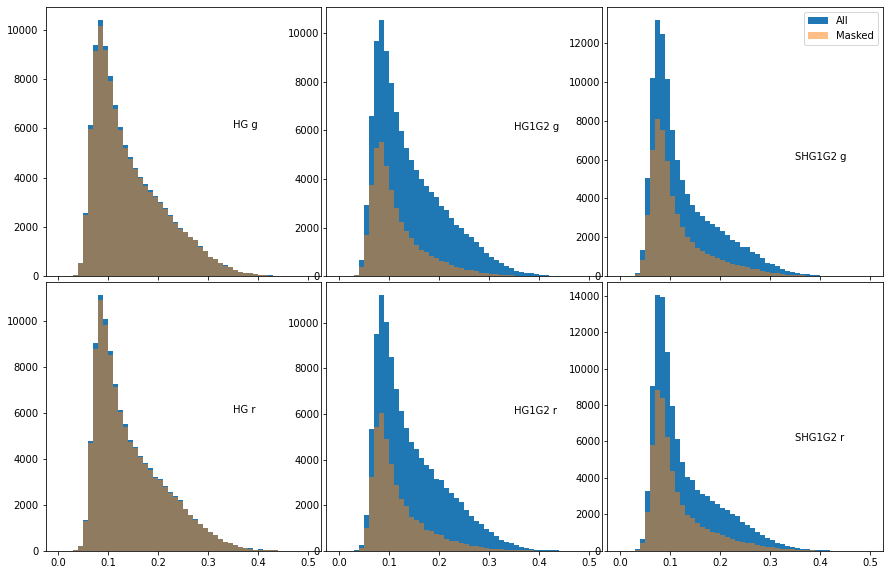

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,0.5]
b = 50

ax[0,0].hist( data.loc[:,'HG_rms_g'], range=r, bins=b, label='All')
ax[0,0].hist( data.loc[mask_HG,'HG_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,0].text( 0.35, 6000, 'HG g')

ax[1,0].hist( data.loc[:,'HG_rms_r'], range=r, bins=b, label='All')
ax[1,0].hist( data.loc[mask_HG,'HG_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,0].text( 0.35, 6000, 'HG r')


ax[0,1].hist( data.loc[:,'HG1G2_rms_g'], range=r, bins=b, label='All')
ax[0,1].hist( data.loc[mask_HG1G2,'HG1G2_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,1].text( 0.35, 6000, 'HG1G2 g')

ax[1,1].hist( data.loc[:,'HG1G2_rms_r'], range=r, bins=b, label='All')
ax[1,1].hist( data.loc[mask_HG1G2,'HG1G2_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,1].text( 0.35, 6000, 'HG1G2 r')


ax[0,2].hist( data.loc[:,'SHG1G2_rms_g'], range=r, bins=b, label='All')
ax[0,2].hist( data.loc[mask_SHG1G2,'SHG1G2_rms_g'], range=r, bins=b, label='Masked', alpha=0.5)
ax[0,2].text( 0.35, 6000, 'SHG1G2 g')

ax[1,2].hist( data.loc[:,'SHG1G2_rms_r'], range=r, bins=b, label='All')
ax[1,2].hist( data.loc[mask_SHG1G2,'SHG1G2_rms_r'], range=r, bins=b, label='Masked', alpha=0.5)
ax[1,2].text( 0.35, 6000, 'SHG1G2 r')
    

ax[0,2].legend(loc='upper right')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_histo.png'), facecolor='white')

- Peak at 0.1 mag
- photometric quality of ZTF alerts @ 0.1mag

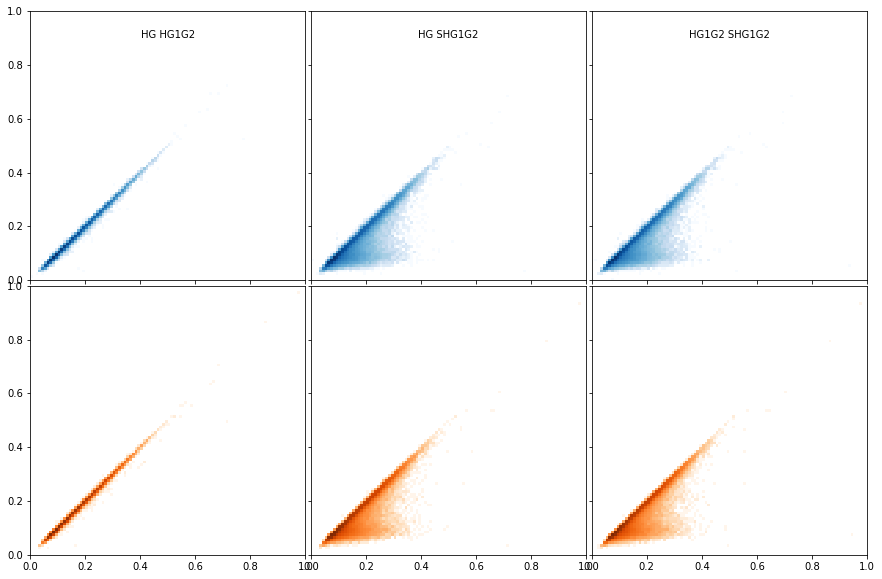

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data['HG_rms_g']
y = data['HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data['HG_rms_r']
y = data['HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')




x = data['HG_rms_g']
y = data['SHG1G2_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data['HG_rms_r']
y = data['SHG1G2_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')




x = data['HG1G2_rms_g']
y = data['SHG1G2_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data['HG1G2_rms_r']
y = data['SHG1G2_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')


ax[0,0].text( 0.5, 0.9, 'HG HG1G2', ha='center')
ax[0,1].text( 0.5, 0.9, 'HG SHG1G2', ha='center')
ax[0,2].text( 0.5, 0.9, 'HG1G2 SHG1G2', ha='center')


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_comparison.png'), facecolor='white')

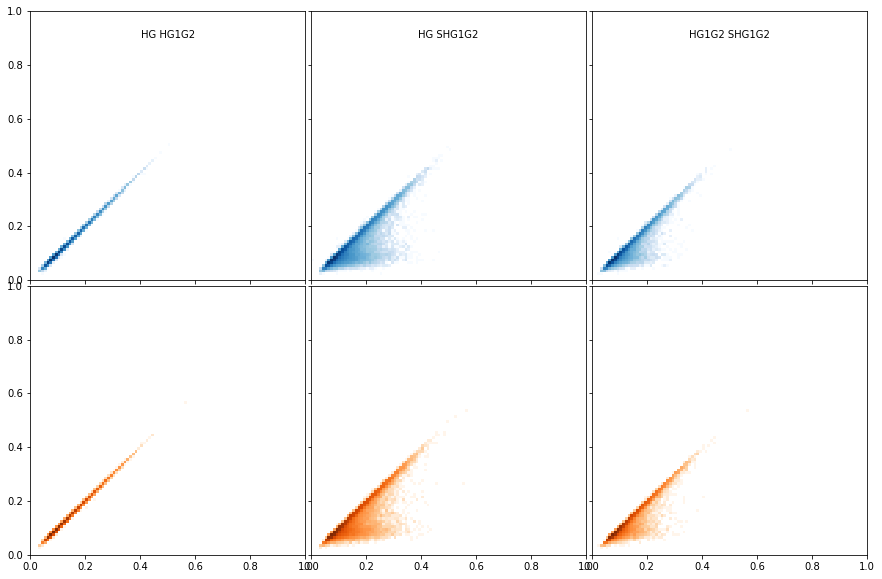

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [0,1]
b = 100

x = data.loc[mask_HG1G2,'HG_rms_g']
y = data.loc[mask_HG1G2,'HG1G2_rms_g']
ax[0,0].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data.loc[mask_HG1G2,'HG_rms_r']
y = data.loc[mask_HG1G2,'HG1G2_rms_r']
ax[1,0].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')


x = data.loc[mask_SHG1G2,'HG_rms_g']
y = data.loc[mask_SHG1G2,'SHG1G2_rms_g']
ax[0,1].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data.loc[mask_SHG1G2,'HG_rms_r']
y = data.loc[mask_SHG1G2,'SHG1G2_rms_r']
ax[1,1].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')


mm = mask_HG1G2 & mask_SHG1G2
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'SHG1G2_rms_g']
ax[0,2].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Blues')

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'SHG1G2_rms_r']
ax[1,2].hist2d( x, y, range=[r,r], bins=b, norm=mpl.colors.LogNorm(), cmap='Oranges')

for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
    
ax[0,0].text( 0.5, 0.9, 'HG HG1G2', ha='center')
ax[0,1].text( 0.5, 0.9, 'HG SHG1G2', ha='center')
ax[0,2].text( 0.5, 0.9, 'HG1G2 SHG1G2', ha='center')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'rms_comparison_masked.png'), facecolor='white')

Text(0.1, 0.8, 'HG1G2 - SHG1G2')

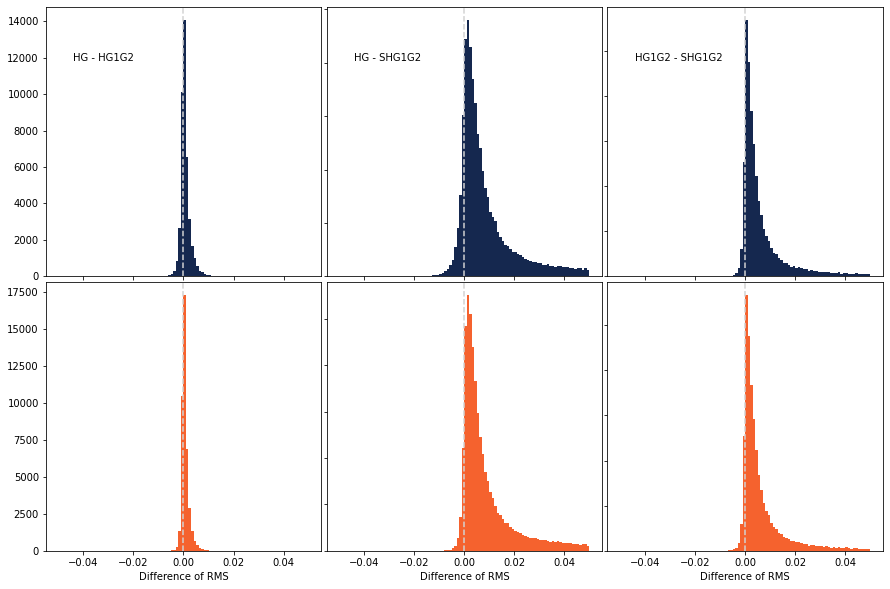

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(15,10), gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-0.05,0.05]
b = 100

x = data.loc[mask_HG1G2,'HG_rms_g']
y = data.loc[mask_HG1G2,'HG1G2_rms_g']
ax[0,0].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_HG1G2,'HG_rms_r']
y = data.loc[mask_HG1G2,'HG1G2_rms_r']
ax[1,0].hist( x-y, range=r, bins=b, color=fink_colors[1])


x = data.loc[mask_SHG1G2,'HG_rms_g']
y = data.loc[mask_SHG1G2,'SHG1G2_rms_g']
ax[0,1].hist( x-y, range=r, bins=b, color=fink_colors[0])

x = data.loc[mask_SHG1G2,'HG_rms_r']
y = data.loc[mask_SHG1G2,'SHG1G2_rms_r']
ax[1,1].hist( x-y, range=r, bins=b, color=fink_colors[1])


mm = mask_HG1G2 & mask_SHG1G2
x = data.loc[mm,'HG1G2_rms_g']
y = data.loc[mm,'SHG1G2_rms_g']

x = data.loc[mm,'HG1G2_rms_r']
y = data.loc[mm,'SHG1G2_rms_r']
ax[0,2].hist( x-y, range=r, bins=b, color=fink_colors[0])
ax[1,2].hist( x-y, range=r, bins=b, color=fink_colors[1])


for a in ax[:,1:].ravel():
    a.set_yticklabels('')
for a in ax[0,:].ravel():
    a.set_xticklabels('')
for a in ax[1,:].ravel():
    a.set_xlabel('Difference of RMS')

for a in ax.ravel():
    a.axvline(0, linestyle='dashed', color='lightgrey' )
    
# ax[0,0].text( -0.04, 1000, 'HG HG1G2', ha='left')
# ax[0,1].text( -0.04, 1000, 'HG SHG1G2', ha='left')
# ax[0,2].text( -0.04, 1000, 'HG1G2 SHG1G2', ha='left')

ax[0,0].text( 0.1, 0.8, 'HG - HG1G2', transform=ax[0,0].transAxes)
ax[0,1].text( 0.1, 0.8, 'HG - SHG1G2', transform=ax[0,1].transAxes)
ax[0,2].text( 0.1, 0.8, 'HG1G2 - SHG1G2', transform=ax[0,2].transAxes)



- use that to get best and worst improvement

In [55]:

cols = ['sso_number','sso_name', 
        'min_phase', 'max_phase', 'n_days', 'n_obs',
        'HG_H_r', 'HG_G_r', 'HG_rms_r', 
        'HG1G2_H_r', 'HG1G2_G1_r', 'HG1G2_G2_r', 'HG1G2_rms_r', 
        'SHG1G2_H_r', 'SHG1G2_G1_r', 'SHG1G2_G2_r', 'SHG1G2_rms_r']

improved = data.loc[mask_HG1G2 & mask_SHG1G2, cols]

improved_from_HG = improved.loc[(improved.HG_rms_r - improved.HG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)
improved_from_HG1G2 = improved.loc[(improved.HG1G2_rms_r - improved.SHG1G2_rms_r).sort_values(ascending=True).index, cols].tail(20)


# Spins

In [56]:
data.columns

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g',
       ...
       'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
       'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique',
       'ztf_pC', 'ztf_pS', 'ztf_complex', 'ztf_pcomplex'],
      dtype='object', length=144)

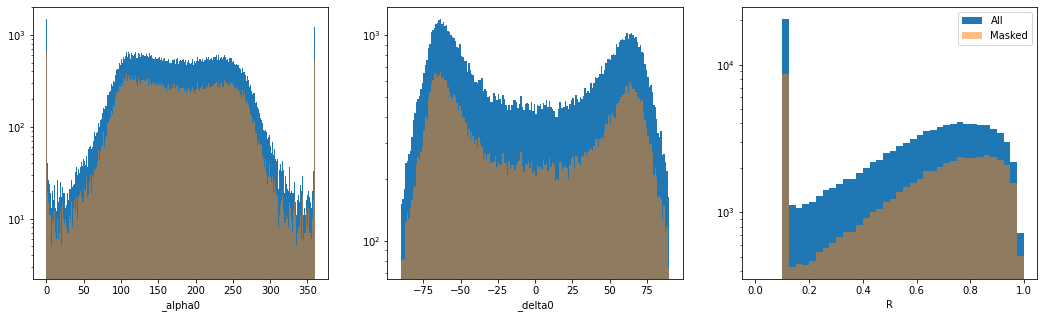

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0,360]
b = 360
ax[0].hist( data.loc[:,'SHG1G2_alpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_SHG1G2,'SHG1G2_alpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [-90,90]
b = 180
ax[1].hist( data.loc[:,'SHG1G2_delta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_SHG1G2,'SHG1G2_delta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'SHG1G2_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_SHG1G2,'SHG1G2_R'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'_alpha0')
ax[1].set_xlabel(f'_delta0')
ax[2].set_xlabel(f'R')

for a in ax:
    a.set_yscale('log')
ax[2].legend(loc='upper right')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'spin_histo.png'), facecolor='white')

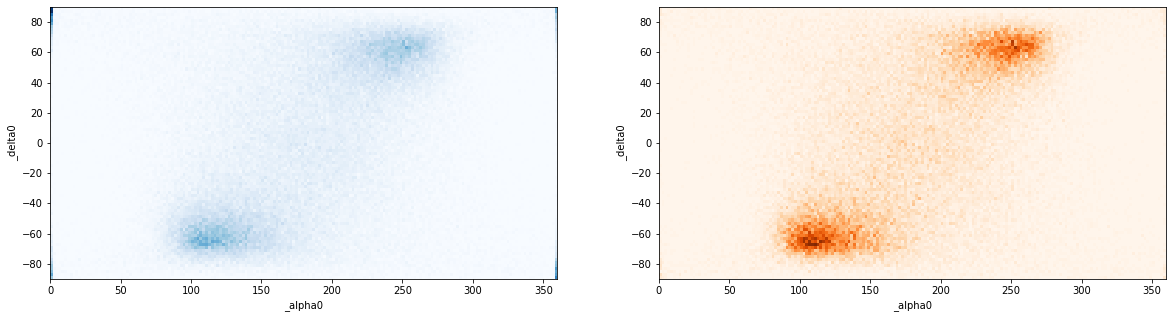

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# ax.scatter( data.loc[:,'SHG1G2_alpha0'], data.loc[:,'SHG1G2__delta0'] )
ax[0].hist2d( data.loc[:,'SHG1G2_alpha0'], data.loc[:,'SHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data.loc[mask_SHG1G2&maskSpin,'SHG1G2_alpha0'], data.loc[mask_SHG1G2&maskSpin,'SHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'_alpha0')
    a.set_ylabel(f'_delta0')


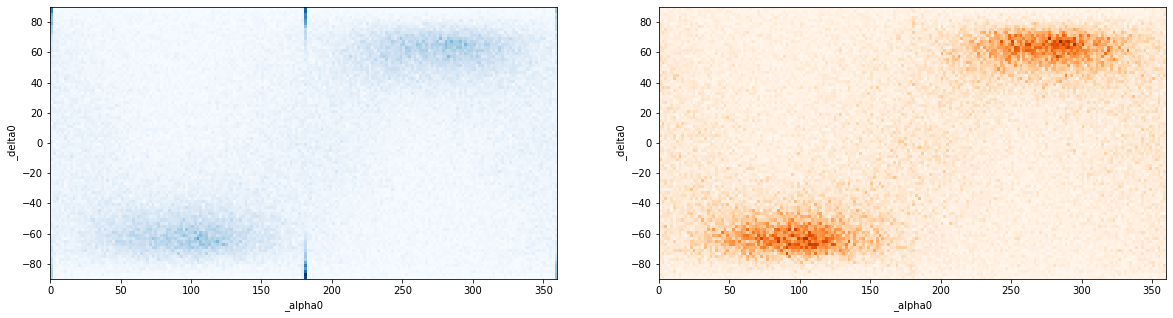

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

r = [[0,360],[-90,90]]
b = [180,90]

# Flip half spins
data_flipped = data.copy()
cond = (data_flipped.index %2 ==0 )
xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

data_flipped.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data_flipped.loc[cond,yax] = -data.loc[cond,yax]

# ax.scatter( data.loc[:,'SHG1G2_alpha0'], data.loc[:,'SHG1G2__delta0'] )
ax[0].hist2d( data_flipped.loc[:,'SHG1G2_alpha0'], data_flipped.loc[:,'SHG1G2_delta0'], range=r, bins=b, cmap='Blues' )

ax[1].hist2d( data_flipped.loc[mask_SHG1G2&maskSpin,'SHG1G2_alpha0'], data_flipped.loc[mask_SHG1G2&maskSpin,'SHG1G2_delta0'], range=r, bins=b, cmap='Oranges' )

for a in ax:
    a.set_xlabel(f'_alpha0')
    a.set_ylabel(f'_delta0')


# Uncertainties on parameters

In [61]:
data.columns[:90]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit', 'SHG1G2_R',
       'SHG1G2_min_cos_lambda', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_G2_g',
       'SHG1G2_G1_r', 'SHG1G2_ddelta0', 'SHG1G2_G1_g', 'std_astrometry',
       'SHG1G2_delta0', 'n_days_r', 'SHG1G2_G2_r', 'n_days_g',
       'SHG1G2_chi2red', 'min_phase', 'SHG1G2_dH_g', 'SHG1G2_dH_r',
       'SHG1G2_rms_r', 'last_jd', 'SHG

Text(0.5, 0, 'dR')

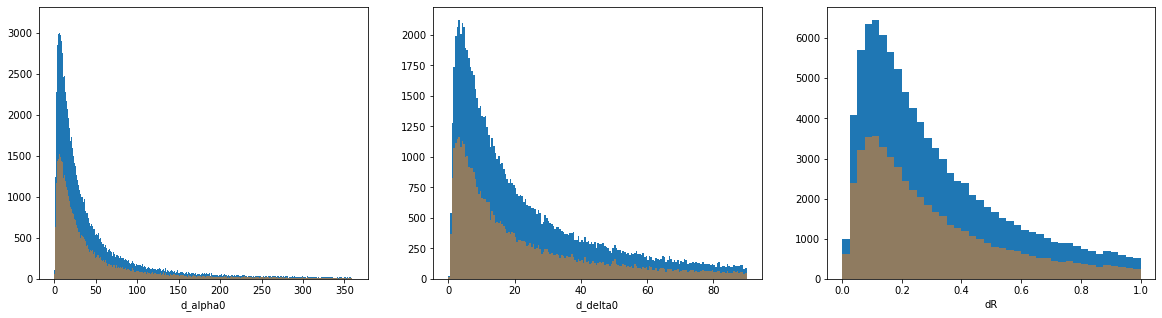

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


r = [0,360]
b = 360
ax[0].hist( data.loc[:,'SHG1G2_dalpha0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask_SHG1G2,'SHG1G2_dalpha0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,90]
b = 180
ax[1].hist( data.loc[:,'SHG1G2_ddelta0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask_SHG1G2,'SHG1G2_ddelta0'], range=r, bins=b, label='Masked', alpha=0.5)

r = [0,1]
b = 40
ax[2].hist( data.loc[:,'SHG1G2_dR'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask_SHG1G2,'SHG1G2_dR'], range=r, bins=b, label='Masked', alpha=0.5)


ax[0].set_xlabel(f'd_alpha0')
ax[1].set_xlabel(f'd_delta0')
ax[2].set_xlabel(f'dR')